In [ ]:
# to access files from google drive.

from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import keras.utils
from keras import applications
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, f1_score
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import os
import cv2
from sklearn import preprocessing

In [ ]:
# Preparing Dataset

x, y = [], []

for disease in os.listdir('drive/MyDrive/PlantDiseaseDatasetNew/'):
  for img in os.listdir('drive/MyDrive/PlantDiseaseDatasetNew/'+ disease):
    x.append(cv2.resize(cv2.imread('drive/MyDrive/PlantDiseaseDatasetNew/'+ disease + '/' + img),(250,250)))
    y.append(disease)

x, y = np.array(x), np.array(y)

print(x.shape,y.shape)


(5634, 250, 250, 3) (5634,)


In [ ]:
# Encoding Class Labels 

le = preprocessing.LabelEncoder()
le.fit(['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Potato___Early_blight',
 'Potato___healthy',
 'Potato___Late_blight',
 'Strawberry___healthy',
 'Strawberry___Leaf_scorch'])
y_ = le.transform(y)

In [ ]:
# Splitting Dataset into Train, Test and Validation sets

X_train, X_test, y_train, y_test = train_test_split(x, y_, test_size=0.10, random_state = 1)

X_train, X_CV, y_train, y_CV = train_test_split(X_train, y_train, test_size=0.10, random_state=1)

In [ ]:
# Normalizing 

X_train = X_train/255
X_test = X_test/255
X_CV = X_CV/255

In [ ]:
# Converting class labels into binary class matrices

y_train = keras.utils.to_categorical(y_train,num_classes=12)
y_test = keras.utils.to_categorical(y_test,num_classes=12)
y_CV = keras.utils.to_categorical(y_CV,num_classes=12)

In [ ]:
# Preparing the model

inc = applications.InceptionV3(input_shape=(250,250,3), weights='imagenet', include_top=False)
inc.trainable = False
print('inception pre trained model is loaded ....')

model = Sequential([inc,
                    Flatten(),
                    Dense(150,activation='tanh'),
                    Dropout(0.5),
                    BatchNormalization(),
                    Dense(12,activation='softmax')
                    ])


inception pre trained model is loaded ....


In [ ]:
# Defining Callback
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)

In [ ]:
# Training model

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-4),
              metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=512, epochs=35, validation_data=(X_CV,y_CV),callbacks=[early_stopping_callback])


Epoch 1/35
9/9 [==============================] - 303s 34s/step - loss: 0.6377 - accuracy: 0.8113 - val_loss: 0.3616 - val_accuracy: 0.8935
Epoch 2/35
9/9 [==============================] - 291s 33s/step - loss: 0.4390 - accuracy: 0.8842 - val_loss: 0.2956 - val_accuracy: 0.9191
Epoch 3/35
9/9 [==============================] - 291s 33s/step - loss: 0.3112 - accuracy: 0.9275 - val_loss: 0.2337 - val_accuracy: 0.9250
Epoch 4/35
9/9 [==============================] - 296s 33s/step - loss: 0.2460 - accuracy: 0.9445 - val_loss: 0.2344 - val_accuracy: 0.9270
Epoch 5/35
9/9 [==============================] - 296s 33s/step - loss: 0.2086 - accuracy: 0.9605 - val_loss: 0.2067 - val_accuracy: 0.9448
Epoch 6/35
9/9 [==============================] - 296s 33s/step - loss: 0.1568 - accuracy: 0.9689 - val_loss: 0.1879 - val_accuracy: 0.9448
Epoch 7/35
9/9 [==============================] - 297s 33s/step - loss: 0.1252 - accuracy: 0.9786 - val_loss: 0.1954 - val_accuracy: 0.9428
Epoch 8/35
9/9 [====

In [ ]:
print("Final accuracy on test set : ", 100*model.evaluate(X_test, y_test)[1], "%")

18/18 [==============================] - 35s 2s/step - loss: 0.1277 - accuracy: 0.9734
Final accuracy on test set :  97.34042286872864 %


In [ ]:
# COHEN KAPPA SCORE ON TEST SET:-
prediction = np.argmax(model.predict(X_test),axis=1)

In [ ]:
print("Cohen Kappa score is : ", cohen_kappa_score(prediction,np.argmax(y_test,axis=1)))

Cohen Kappa score is :  0.9709416153164478


In [ ]:
# F1 SCORE ON TEST SET :-
print("F1 score is : ", f1_score(prediction,np.argmax(y_test,axis=1), average = 'macro'))

F1 score is :  0.9749956022972909


Confusion Matrix is : 


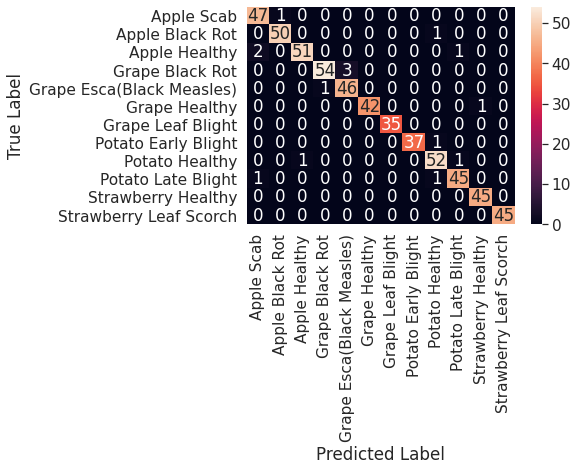

In [ ]:
# CONFUSION MATRIX
conf_matrix = confusion_matrix(np.argmax(y_test,axis=1),prediction)

print("Confusion Matrix is : ")

df = pd.DataFrame(conf_matrix,columns=['Apple Scab',
 'Apple Black Rot',
 'Apple Healthy',
 'Grape Black Rot',
 'Grape Esca(Black Measles)',
 'Grape Healthy',
 'Grape Leaf Blight',
 'Potato Early Blight',
 'Potato Healthy',
 'Potato Late Blight',
 'Strawberry Healthy',
 'Strawberry Leaf Scorch'],index = ['Apple Scab',
 'Apple Black Rot',
 'Apple Healthy',
 'Grape Black Rot',
 'Grape Esca(Black Measles)',
 'Grape Healthy',
 'Grape Leaf Blight',
 'Potato Early Blight',
 'Potato Healthy',
 'Potato Late Blight',
 'Strawberry Healthy',
 'Strawberry Leaf Scorch'] )
sn.set(font_scale=1.4)
sn.heatmap(df,annot=True,fmt='d')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()